# T-725 Natural Language Processing: Lab 4
In today's lab, we will be working with part-of-speech tagging, parsing, and chunking.

To begin with, do the following:
* Select `"File" > "Save a copy in Drive"` to create a local copy of this notebook that you can edit.
* Select `"Runtime" > "Run all"` to run the code in this notebook.

## Setting up
Let's start off by installing the `svgling` library for drawing syntax trees, as well as defining a function to evaluate the grammars that we will be creating in today's lab assignment.

In [138]:
!pip install svgling

In [139]:
# Compare trees generated by a parser to correct trees

def evaluate_parser(parser, sentences, correct):
  correct_trees = [nltk.Tree.fromstring(t) for t in correct]
  num_sentences = len(sentences)

  for num, (sent, correct_tree) in enumerate(zip(sentences, correct_trees)):
    print(f">{sent}\n")

    error = None
    print_tree = False

    try:
      my_trees = list(parser.parse(sent.split()))
    except ValueError as e:
      print(e)
      my_trees = []

    if len(my_trees) > 1:
      error = f"Generated {len(my_trees)} trees (should only generate one)!"
    elif len(my_trees) == 0:
      error = "Couldn't parse sentence."
    else:
      my_tree = my_trees[0]
      if my_tree != correct_tree:
        error = "Generated an incorrect tree"
        print_tree = True

    if error:
      print(error)

      if print_tree:
        print("\nYour tree:")
        my_tree.pretty_print()

      print("\nCorrect tree:")
      correct_tree.pretty_print()
    else:
      print("Correct!\n")

    if num != num_sentences - 1:
      print("============================")

## Context free grammars (CFG) in NLTK

[Example 3.1](https://www.nltk.org/book/ch08.html#sec-context-free-grammar) in chapter 8 of the NLTK book shows how we define a context free grammar (CFG) and use it to parse sentences.

In [140]:
import nltk

grammar1 = nltk.CFG.fromstring("""
  S -> NP VP
  VP -> V NP | V NP PP
  PP -> P NP
  V -> "saw" | "ate" | "walked"
  NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
  Det -> "a" | "an" | "the" | "my"
  N -> "man" | "dog" | "cat" | "telescope" | "park"
  P -> "in" | "on" | "by" | "with"
  """)

sent = "Mary saw Bob".split()
rd_parser = nltk.RecursiveDescentParser(grammar1)
for tree in rd_parser.parse(sent):
  print(tree)

(S (NP Mary) (VP (V saw) (NP Bob)))


## Visualizing parse trees with NLTK
We can use NLTK to draw a graphical diagram of a syntax tree. Unfortunately, this functionality does not work on Google Colab. We can still print it as text:

In [141]:
from nltk import Tree
t = Tree.fromstring('(S (NP this tree) (VP (V is) (ADJ pretty)))')

# NLTK won't draw the tree if we're using Google Colab
# t.draw()

# But we can still print a text diagram
t.pretty_print()

               S                
       ________|_______          
      |                VP       
      |             ___|____     
      NP           V       ADJ  
  ____|___         |        |    
this     tree      is     pretty


We can also use a different library, `svgling`, to draw trees:

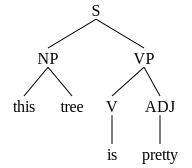

In [142]:
import svgling

svgling.draw_tree(t)

## Probabilistic context free grammar (PCFG) in NLTK
[Example 6.4](https://www.nltk.org/book/ch08.html#code-pcfg1) in chapter 8 of the NLTK book shows how to define a probabilistic context free grammar (PCFG) and use it to produce the most likely tree for a given sentence. Note that the productions for each category must add up to 1.0.

In [143]:
import nltk

grammar = nltk.PCFG.fromstring("""
    S    -> NP VP              [1.0]
    VP   -> TV NP              [0.4]
    VP   -> IV                 [0.3]
    VP   -> DatV NP NP         [0.3]
    TV   -> 'saw'              [1.0]
    IV   -> 'ate'              [1.0]
    DatV -> 'gave'             [1.0]
    NP   -> 'telescopes'       [0.8]
    NP   -> 'Jack'             [0.2]
    """)

viterbi_parser = nltk.ViterbiParser(grammar)

for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']):
  print(tree)

(S (NP Jack) (VP (TV saw) (NP telescopes))) (p=0.064)


This is equivalent to:

In [144]:
grammar = nltk.PCFG.fromstring("""
    S    -> NP VP [1.0]
    VP   -> TV NP [0.4] | IV [0.3] | DatV NP NP [0.3]
    TV   -> 'saw' [1.0]
    IV   -> 'ate' [1.0]
    DatV -> 'gave' [1.0]
    NP   -> 'telescopes' [0.8] | 'Jack' [0.2]
    """)

viterbi_parser = nltk.ViterbiParser(grammar)

for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']):
  print(tree)

(S (NP Jack) (VP (TV saw) (NP telescopes))) (p=0.064)


## Chunking with NLTK
NLTK's taggers can be used for more than just assigning part-of-speech tags to tokens. They can also be trained to assign chunk tags to chunks. [Example 3.1](https://www.nltk.org/book/ch07.html#code-unigram-chunker) in chapter 7 of the NLTK book shows how to build a chunker with a unigram tagger:

In [145]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]

        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

We can train it and evaluate it on the CoNLL 2000 corpus, which contains chunk IOB tags (I-inside, O-outside, B-begin) as well as POS tags.

In [146]:
from nltk.corpus import conll2000
nltk.download('conll2000')
nltk.download('averaged_perceptron_tagger')

test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])

chunker = UnigramChunker(train_sents)

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\pasqu\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pasqu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Now that we've trained an NP chunker, we can try chunking a sentence:

(S
  (NP The/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat./NN))


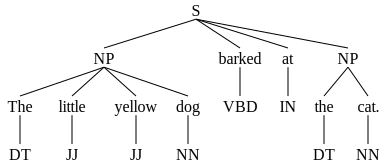

In [147]:
import svgling
sentence = nltk.pos_tag('The little yellow dog barked at the cat.'.split())

tree = chunker.parse(sentence)
print(tree)

# Note that we can't pretty_print() partial trees, but we can still draw them
# using svgling
svgling.draw_tree(tree)

We can also see how well the chunker performs by evaluating it on the test set:

In [148]:
print(chunker.evaluate(test_sents))

C:\Users\pasqu\AppData\Local\Temp\ipykernel_29452\2809867139.py:1: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print(chunker.evaluate(test_sents))


ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


# Assignment
Answer the following questions and hand in your solution in Canvas before 8:30 Monday morning, September 25th. Remember to save your file before uploading it.

## Question 1
Part-of-Speech Tagging

Complete the following tasks:
1. Use `gutenberg.sents(filename)` to get the tokenized sentences of *The Innocence of Father Brown* by G. K. Chesterton (`chesterton-brown.txt`).
2. Tag the sentences using `nltk.pos_tag_sents(tokenized_sentences)`.
3. Use a list comprehension to create a single list with all the tags.
4. Use `nltk.FreqDist()` to count the tags, and generate a frequency list (with all the tags) using `.most_common()`.


In [149]:
from nltk.corpus import gutenberg
nltk.download('gutenberg')

# Required for nltk.pos_tag_sents()
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\pasqu\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pasqu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pasqu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [150]:
# Your solution here
from nltk import FreqDist
tokenized_sentences = gutenberg.sents('chesterton-brown.txt')
tagged_sentences = nltk.pos_tag_sents(tokenized_sentences)
all_tags = [tag for sent in tagged_sentences for (word, tag) in sent]
freq_list = FreqDist(all_tags).most_common()
print(freq_list)

[('NN', 12969), ('IN', 9389), ('DT', 8447), ('JJ', 5935), ('PRP', 5485), ('VBD', 5168), ('RB', 4475), (',', 4069), ('NNP', 3664), ('CC', 3292), ('.', 2918), ('NNS', 2582), ('VB', 2419), ('VBN', 1787), (':', 1745), ('PRP$', 1571), ('VBP', 1510), ('TO', 1391), ('VBG', 1239), ('VBZ', 964), ('MD', 829), ("''", 614), ('CD', 504), ('RP', 419), ('WP', 413), ('WDT', 410), ('WRB', 359), ('POS', 298), ('JJR', 222), ('EX', 202), ('RBR', 182), ('JJS', 150), ('PDT', 122), ('(', 57), ('``', 50), ('RBS', 49), (')', 43), ('SYM', 31), ('FW', 28), ('UH', 26), ('NNPS', 19), ('WP$', 17)]


## Question 2
Add to `q1_grammar` below until the sentence can be correctly parsed.

In [151]:
q1_grammar = nltk.CFG.fromstring("""
  S  -> NP VP
  NP -> NP PP | N
  VP -> V NP | V ADJ
  PP -> P NP
  N -> 'sunsets' | 'mars'
  V -> 'are'
  ADJ -> 'blue'
  P -> 'on'
  """)

q1_parser = nltk.ChartParser(q1_grammar)

# Evaluate the parser
q1_sents = ["sunsets on mars are blue"]
q1_correct = ["(S (NP (NP (N sunsets)) (PP (P on) (NP (N mars)))) (VP (V are) (ADJ blue)))"]

evaluate_parser(q1_parser, q1_sents, q1_correct)

>sunsets on mars are blue

Correct!


## Question 3
Make the following changes to `q2_grammar` below:
1. Replace the noun category (N) with singular nouns (NN) and plural nouns (NNS).
2. Add a category for cardinal numbers (CD).
3. Add a category for adverbs (ADV).
4. Add a category for personal pronouns (PRP).

Adjust your grammar so that the sentences below are parsed correctly.

In [152]:
q2_grammar = nltk.CFG.fromstring("""
  S  -> NP VP
  NP -> NP PP | DT ADJ NN | DT NN | PRP NN | CD ADJ NNS | NN | NNS
  VP -> V NP | V PP
  PP -> P NP | ADV P NP
  DT -> 'the'
  NN -> 'venus' | 'planet' | 'sun' | 'life' | 'saturn' | 'earth'
  NNS -> 'moons'
  ADJ -> 'closest' | 'known'
  V -> 'is' | 'has'
  P -> 'to' | 'through'
  CD -> '82'
  ADV -> 'halfway'
  PRP -> 'its'
""")

q2_parser = nltk.ChartParser(q2_grammar)

# Facts
q2_facts = [
    "venus is the closest planet to earth",
    "the sun is halfway through its life",
    "saturn has 82 known moons"
]

# Evaluate the parser
q2_correct = [
    "(S (NP (NN venus)) (VP (V is) (NP (NP (DT the) (ADJ closest) (NN planet)) (PP (P to) (NP (NN earth))))))",
    "(S (NP (DT the) (NN sun)) (VP (V is) (PP (ADV halfway) (P through) (NP (PRP its) (NN life)))))",
    "(S (NP (NN saturn)) (VP (V has) (NP (CD 82) (ADJ known) (NNS moons))))"
]

evaluate_parser(q2_parser, q2_facts, q2_correct)

>venus is the closest planet to earth

Correct!

>the sun is halfway through its life

Correct!

>saturn has 82 known moons

Correct!


## Question 4
Replace the verb category (V) with transitive (TV) and intransitive (IV) verbs and adjust the grammar so that the sentences below are correctly parsed.

In [153]:
q3_grammar = nltk.CFG.fromstring("""
  S  -> NP VP
  NP -> DT N N | N | CD
  VP -> IV PP PP | TV NP PP
  PP -> P NP
  DT -> 'the'
  N -> 'curiosity' | 'rover' | 'mars' | 'nasa' | 'perseverence'
  TV -> 'launched'
  IV -> 'arrived'
  P -> 'on' | 'in'
  CD -> '2012' | '2020'
  """)

q3_parser = nltk.ChartParser(q3_grammar)

# Facts
q3_facts = [
    "the curiosity rover arrived on mars in 2012",
    "nasa launched the perseverence rover in 2020"
]

# Evaluate the parser
q3_correct = [
    "(S (NP (DT the) (N curiosity) (N rover)) (VP (IV arrived) (PP (P on) (NP (N mars))) (PP (P in) (NP (CD 2012)))))",
    "(S (NP (N nasa)) (VP (TV launched) (NP (DT the) (N perseverence) (N rover)) (PP (P in) (NP (CD 2020)))))"
]

evaluate_parser(q3_parser, q3_facts, q3_correct)

>the curiosity rover arrived on mars in 2012

Correct!

>nasa launched the perseverence rover in 2020

Correct!


## Question 5
The following grammar produces two trees for the sentence *John saw a man with binoculars*. Each tree represents a different interpretation of the sentence. One tree implies that John used binoculars to see a man, while the other implies that a man with binoculars was seen by John.

Change the grammar into a **probabilistic CFG** and replace the `ChartParser` with a `ViterbiParser`, which only outputs the most probable tree. Adjust the probabilities so that the parser produces the tree that implies that John saw a man who had binoculars.

In [154]:
from nltk import ViterbiParser
q1_grammar = nltk.PCFG.fromstring("""
  S -> NP VP [1.0]
  NP -> N [0.2] | NP PP [0.4] | DT N [0.4]
  VP -> V NP [0.7] | V NP PP [0.3]
  PP -> P NP [1.0]
  V -> "saw" [1.0]
  DT -> "a" [1.0]
  N -> "John" [0.1] | "man" [0.45] | "binoculars" [0.45]
  P -> "with" [1.0]
""")

sentence = "John saw a man with binoculars".split()

q1_parser = ViterbiParser(q1_grammar)
trees = q1_parser.parse(sentence)

for tree in trees:
  print(tree)
  tree.pretty_print()
  print()

(S
  (NP (N John))
  (VP
    (V saw)
    (NP (DT a) (N man))
    (PP (P with) (NP (N binoculars))))) (p=9.72e-05)
          S                             
  ________|_______                       
 |                VP                    
 |     ___________|________              
 |    |       |            PP           
 |    |       |        ____|______       
 NP   |       NP      |           NP    
 |    |    ___|___    |           |      
 N    V   DT      N   P           N     
 |    |   |       |   |           |      
John saw  a      man with     binoculars



## Question 6
Create a new class, `TrigramChunker`, based on the `UnigramChunker` class defined earlier in the notebook. Modify it so that `self.tagger` is a trigram tagger with a unigram tagger as a backoff (see [5.4 Combining taggers](http://www.nltk.org/book/ch05.html#combining-taggers) in the NLTK book). Train and evaluate your chunker on the CoNLL 2000 corpus (using `train_sents` and `test_sents`, created earlier) and report the results.

In [155]:
# Your solution here
class TrigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]

        self.tagger = nltk.UnigramTagger(train_data, backoff=nltk.TrigramTagger(train_data))

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
    
chunker = TrigramChunker(train_sents)
print(chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


## Question 7
Complete the following tasks:

1. Create a list of all tagged sentences from `test.txt` in the `conll2000` corpus using its `tagged_sents(filename)` method.

2. This should return a list of 2012 tagged sentences. You can access a sentence from the list by its index, e.g., `tagged_sents_list[0]` will return the first tagged sentence. Parse any three of the tagged sentences with your chunker and draw the trees using `svgling.draw_tree(tree)`. Note that the tree will only be drawn if the `draw_tree` method is called at the end of the code block.

3. Compare the trees generated by your chunker to the correct trees in `test_sents` (which contains the same sentences in the same order as those returned by the `tagged_sents` method). Does your chunker make any mistakes? If so, give an example of at least one of those mistakes.

In [156]:
# Your solution here
from nltk.corpus import conll2000
import random
nltk.download('conll2000')

# 1
tagged_sents_list = conll2000.tagged_sents('test.txt')
assert len(tagged_sents_list) == 2012

#2
trees = [None] * 3

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\pasqu\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


Sentence 1:
(S
  ``/``
  (NP Noriega/NNP)
  played/VBD
  (NP U.S./NNP intelligence/NN agencies/NNS)
  and/CC
  (NP the/DT U.S./NNP government/NN)
  like/IN
  (NP a/DT violin/NN)
  ,/,
  ''/''
  (NP he/PRP)
  says/VBZ
  ./.)

Test: 
 (S
  ``/``
  (NP Noriega/NNP)
  played/VBD
  (NP U.S./NNP intelligence/NN agencies/NNS)
  and/CC
  (NP the/DT U.S./NNP government/NN)
  like/IN
  (NP a/DT violin/NN)
  ,/,
  ''/''
  (NP he/PRP)
  says/VBZ
  ./.)


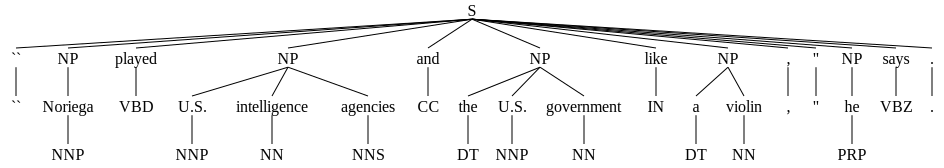

In [157]:
# Sentence 1
random.seed(1)
rnd = random.randint(0, len(tagged_sents_list))
first_sentence = tagged_sents_list[rnd]
trees[0] = chunker.parse(first_sentence)
print('Sentence 1: this tree is equivalent to the correct tree')
print(trees[0])
print('\nTest: \n',test_sents[rnd])
svgling.draw_tree(trees[0])

Sentence 2:
(S
  (NP An/DT analyst/NN)
  cited/VBD
  (NP weaker/JJR capital/NN spending/NN)
  and/CC
  (NP exports/NNS)
  ./.)

Test: 
 (S
  (NP An/DT analyst/NN)
  cited/VBD
  (NP weaker/JJR capital/NN spending/NN and/CC exports/NNS)
  ./.)


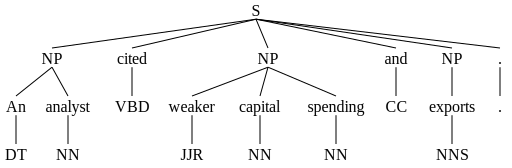

In [158]:
# Sentence 2
random.seed(2)
rnd = random.randint(0, len(tagged_sents_list))
first_sentence = tagged_sents_list[rnd]
trees[1] = chunker.parse(first_sentence)
# TODO: finish this
print('Sentence 2: This tree...')
print(trees[1])
print('\nTest: \n',test_sents[rnd])
svgling.draw_tree(trees[1])

Sentence 3:
(S
  (NP Coca-Cola/NNP Enterprises/NNPS)
  ,/,
  (NP which/WDT)
  is/VBZ
  (NP 49%-owned/JJ)
  by/IN
  (NP Coca-Cola/NNP Co./NNP)
  ,/,
  also/RB
  said/VBD
  (NP it/PRP)
  repurchased/VBD
  about/IN
  (NP 1.2/CD million/CD)
  of/IN
  (NP its/PRP$ common/JJ shares/NNS)
  during/IN
  (NP the/DT third/JJ quarter/NN)
  ./.)

Test: 
 (S
  (NP Coca-Cola/NNP Enterprises/NNPS)
  ,/,
  (NP which/WDT)
  is/VBZ
  49%-owned/JJ
  by/IN
  (NP Coca-Cola/NNP Co./NNP)
  ,/,
  also/RB
  said/VBD
  (NP it/PRP)
  repurchased/VBD
  (NP about/IN 1.2/CD million/CD)
  of/IN
  (NP its/PRP$ common/JJ shares/NNS)
  during/IN
  (NP the/DT third/JJ quarter/NN)
  ./.)


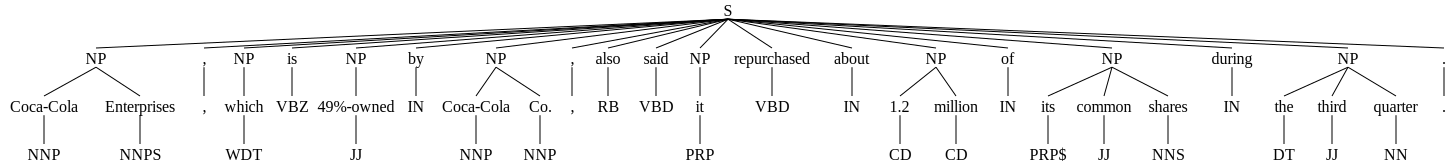

In [159]:
# Sentence 3
random.seed(3)
rnd = random.randint(0, len(tagged_sents_list))
first_sentence = tagged_sents_list[rnd]
trees[2] = chunker.parse(first_sentence)
print('Sentence 3:')
print(trees[2])
print('\nTest: \n',test_sents[rnd])
svgling.draw_tree(trees[2])